In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
np.set_printoptions(precision=2, suppress=True)
plt.rcParams.update({'font.size': 14})

In [2]:
save_file = open('data0928/daily_data_matrix_all_0928.npy','rb')
raw_indicator = np.load(save_file)
raw_preds = np.load(save_file)
raw_conf = np.load(save_file)
raw_wager = np.load(save_file)
raw_se = np.load(save_file)
raw_truth = np.load(save_file)
raw_openday = np.load(save_file)
raw_user_type = np.load(save_file)
raw_user_id = np.load(save_file)
raw_preds_age = np.load(save_file)
save_file.close()

ifps_data = pd.read_csv("data0928/ifps0928_refined.csv")
raw_ifps_type = ifps_data['type'].values

In [3]:
marked_se = np.array(raw_se)
marked_se[marked_se<-0.1] = np.NAN
marked_se[raw_openday<1] = np.NAN

rel_marked_se = marked_se - np.nanmedian(marked_se, axis=2)[:, :, None]

#nan_mark = 1.0 * np.ones_like(raw_openday)
#nan_mark[raw_openday<-0.1] = np.NAN
#se_marked_with_nan *= nan_mark[:, :, None]
#avg_daily_se = np.nanmean(se_marked_with_nan, axis=0)

/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:879: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [5]:
t, n, m, o = raw_preds.shape
type_list = []
se_list = []

user_type_list = []
user_id_list = []
user_num_ifps_list = []
user_num_preds_list = []
user_avg_rel_ADSE_list = []
user_avg_abs_ADSE_list = []
user_num_resolved_ifp_answered_list = []
user_percent_resolved_ifp_answered_list = []
curr_sum_rel_ADSE = np.zeros(m)
curr_sum_abs_ADSE = np.zeros(m)
curr_num_ifps = np.zeros(m)
curr_num_preds = np.zeros(m)
curr_ifp_user_matrix = np.zeros((n, m))
curr_num_resolved_ifp_answered = np.zeros(m)
curr_percent_resolved_ifp_answered = np.zeros(m)


pred_list = []
update_list = []
frequency_list = []
days_before_resolve = np.nanmax(raw_openday, axis=0)
resolved_ifps = np.zeros(n)
ahead_days_list = []
ahead_percent_list = []
variance_list = [] # To do

for h in range(t): # days
    if h%20==0: print(h)
    for j in range(m): # users
        num_preds_today = 0
        for i in np.argwhere(raw_openday[h, :]>0): # ifps
            if raw_preds_age[h, i, j]!=0: continue
            if days_before_resolve[i]<1: continue # one IFP is resolved before open
            # IFP dependent features
            type_list.append(raw_ifps_type[i])
            
            # user dependent features
            user_type_list.append(raw_user_type[j])
            user_id_list.append(raw_user_id[j])
            user_num_ifps_list.append(curr_num_ifps[j])
            user_num_preds_list.append(curr_num_preds[j])
            tmp_num = curr_num_resolved_ifp_answered[j]
            if tmp_num>0:
                user_num_resolved_ifp_answered_list.append(tmp_num)
                user_percent_resolved_ifp_answered_list.append(curr_percent_resolved_ifp_answered[j])
                user_avg_rel_ADSE_list.append(curr_sum_rel_ADSE[j]/tmp_num)
                user_avg_abs_ADSE_list.append(curr_sum_abs_ADSE[j]/tmp_num)
            else:
                user_num_resolved_ifp_answered_list.append(0)
                user_percent_resolved_ifp_answered_list.append(np.NAN)
                user_avg_rel_ADSE_list.append(np.NAN)
                user_avg_abs_ADSE_list.append(np.NAN)
                                 
            # IFP x user dependent features
            pred_list.append(raw_preds[h, i, j]) 
            updates = np.nansum(raw_preds_age[:h, i, j]==0) #this pred doesn't count into curr update
            update_list.append(updates) 
            frequency_list.append((updates+1)/raw_openday[h,i]) # this pred counts into curr frequenc
            ahead_days_list.append(days_before_resolve[i]-raw_openday[h,i])
            ahead_percent_list.append(raw_openday[h,i] / days_before_resolve[i])
            se_list.append(rel_marked_se[h, i, j])
            
            # Accumalates time-variant user features accross IFPs within one day
            curr_ifp_user_matrix[i, j] = 1
            num_preds_today += 1
            
        # Daily updates time-variant user features used for tommorrow     
        curr_num_preds[j] += num_preds_today
        curr_num_ifps[j] = np.sum(curr_ifp_user_matrix[:, j])
    
    # Daily updates time-variant user features used for tommorrow 
    for i in range(n):
        if raw_openday[h, i]==-2 and raw_openday[h-1, i]>-2:
            resolved_ifps[i] = 1
            for j in range(m):
                curr_sum_abs_ADSE[j] += np.nanmean(marked_se[:h+1, i, j])
                curr_sum_rel_ADSE[j] += np.nanmean(rel_marked_se[:h+1, i, j])
        
    num_total_resolved_ifps = np.sum(resolved_ifps)
    if num_total_resolved_ifps>0:
        for j in range(m):
            curr_num_resolved_ifp_answered[j] = np.sum((curr_ifp_user_matrix[:, j]>0) & (resolved_ifps>0))
            curr_percent_resolved_ifp_answered[j] = curr_num_resolved_ifp_answered[j] / num_total_resolved_ifps

print("complete!")

0


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice


20
40
60
80
100
120
140
160
180
complete!


/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2   0.22
  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44  0.46
  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66  0.68  0.7
  0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9   0.92  0.94
  0.96  0.98  1.  ]


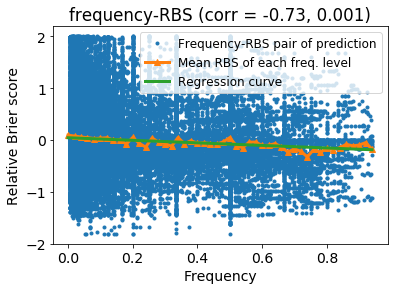

frequency-RBS correlation:
(-0.73835057083639566, 2.1056898641389696e-09)
(-0.08037855641195038, 1.5946724009491662e-128)


In [13]:
frequency = np.array(frequency_list).squeeze()
se_label = np.array(se_list).squeeze()

valid = (~np.isnan(frequency)) & (frequency<1) & (~np.isnan(se_label))
frequency = frequency[valid]
se_label = se_label[valid]

percentiles = 50
#perc_mean_preds = np.zeros(percentiles+1)
#perc_mean_entr = np.zeros(percentiles+1)
#perc_mean_wager = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
#perc_mean_mse_rate = np.zeros(percentiles+1)
#perc_mean_rank = np.zeros(percentiles+1)
for i in range(percentiles+1):
    center = 1 / percentiles * i
    head = center - 1 / percentiles * 0.5
    tail = center + 1 / percentiles * 0.5
    valid = (frequency>=head) & (frequency<tail)
    #perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    #perc_mean_entr[i] = np.mean(vec_entr[valid])
    #perc_mean_rank[i] = np.mean(vec_rank[valid])
    #perc_mean_wager[i] = np.mean(vec_wager[valid & vec_valid_wager])
    perc_mean_mse[i] = np.mean(se_label[valid])
    #perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
x_axis = np.arange(percentiles+1) / percentiles
print(x_axis)

plt.figure(1)
plt.plot(frequency, se_label,'.', label="Frequency-RBS pair of prediction")
plt.plot(x_axis, perc_mean_mse, '-^', linewidth=3, markersize=6, label="Mean RBS of each freq. level")
x = x_axis[~np.isnan(perc_mean_mse)]
y = perc_mean_mse[~np.isnan(perc_mean_mse)]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
#plt.ylim([-0.03,1.05])
#plt.title('Conf-entr')
plt.xlabel('Frequency')
plt.ylabel('Relative Brier score')
plt.legend(prop={'size': 12})
plt.title('frequency-RBS (corr = -0.73, 0.001)')
plt.savefig('fig0928/frequency_RBS.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close('All')
print('frequency-RBS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))
print(st.pearsonr(frequency, se_label))

(100014,) (100014,) (100014,)
[ 0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4   0.44
  0.48  0.52  0.56  0.6   0.64  0.68  0.72  0.76  0.8   0.84  0.88  0.92
  0.96  1.    1.04  1.08  1.12  1.16  1.2   1.24  1.28  1.32  1.36  1.4
  1.44  1.48  1.52  1.56  1.6   1.64  1.68  1.72  1.76  1.8   1.84  1.88
  1.92  1.96  2.  ]


/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


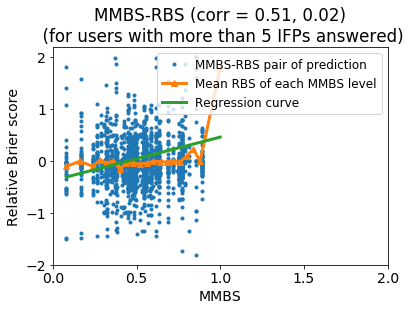

MMBS-RBS correlation:
(0.51606429201106785, 0.01984261857990343)


In [15]:
avg_abs_ADBS = np.array(user_avg_abs_ADSE_list).squeeze()
num_resolved_ifp = np.array(user_num_resolved_ifp_answered_list).squeeze()
se_label = np.array(se_list).squeeze()

print(avg_abs_ADBS.shape, num_resolved_ifp.shape, se_label.shape)

valid = (~np.isnan(avg_abs_ADBS)) & (num_resolved_ifp>=5) & (~np.isnan(se_label))
#print(valid.shape)
avg_abs_ADBS = avg_abs_ADBS[valid]
se_label = se_label[valid]

#print(np.max(num_resolved_ifp))
#print(avg_abs_ADBS)
#print(se_label)


percentiles = 50
interval = 2
#perc_mean_preds = np.zeros(percentiles+1)
#perc_mean_entr = np.zeros(percentiles+1)
#perc_mean_wager = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
#perc_mean_mse_rate = np.zeros(percentiles+1)
#perc_mean_rank = np.zeros(percentiles+1)
for i in range(percentiles+1):
    center = interval / percentiles * i
    head = center - interval / percentiles * 0.5
    tail = center + interval / percentiles * 0.5
    valid = (avg_abs_ADBS>=head) & (avg_abs_ADBS<tail)
    #perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    #perc_mean_entr[i] = np.mean(vec_entr[valid])
    #perc_mean_rank[i] = np.mean(vec_rank[valid])
    #perc_mean_wager[i] = np.mean(vec_wager[valid & vec_valid_wager])
    perc_mean_mse[i] = np.mean(se_label[valid])
    #perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
x_axis = np.arange(percentiles+1) / percentiles * interval
print(x_axis)

plt.figure(1)
plt.plot(avg_abs_ADBS, se_label,'.', label="MMBS-RBS pair of prediction")
x = x_axis[~np.isnan(perc_mean_mse)]
y = perc_mean_mse[~np.isnan(perc_mean_mse)]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
plt.plot(x, y, '-^', linewidth=3, markersize=6, label="Mean RBS of each MMBS level")
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
plt.xlim([0,0+interval])
plt.xlabel('MMBS')
plt.ylabel('Relative Brier score')
plt.legend(prop={'size': 12})
plt.title('MMBS-RBS (corr = 0.51, 0.02)\n (for users with more than 5 IFPs answered)')
plt.savefig('fig0928/MMBS_RBS.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close('All')
print('MMBS-RBS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))

(100014,) (100014,) (100014,)


/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


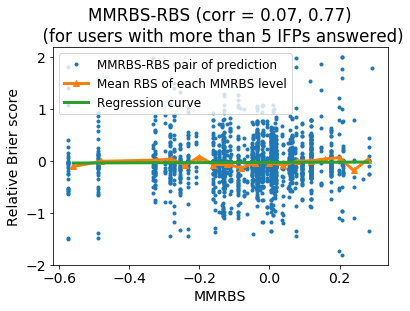

MMRBS-RBS correlation:
(0.071691408689039546, 0.77741576175169635)


In [17]:
avg_rel_ADBS = np.array(user_avg_rel_ADSE_list).squeeze()
num_resolved_ifp = np.array(user_num_resolved_ifp_answered_list).squeeze()
se_label = np.array(se_list).squeeze()

print(avg_rel_ADBS.shape, num_resolved_ifp.shape, se_label.shape)

valid = (~np.isnan(avg_rel_ADBS)) & (num_resolved_ifp>=5) & (~np.isnan(se_label))
#print(valid.shape)
avg_rel_ADBS = avg_rel_ADBS[valid]
se_label = se_label[valid]

#print(np.max(num_resolved_ifp))
#print(avg_abs_ADBS)
#print(se_label)


percentiles = 100
interval = 4
#perc_mean_preds = np.zeros(percentiles+1)
#perc_mean_entr = np.zeros(percentiles+1)
#perc_mean_wager = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
#perc_mean_mse_rate = np.zeros(percentiles+1)
#perc_mean_rank = np.zeros(percentiles+1)
for i in range(percentiles+1):
    center = interval / percentiles * i - 2
    head = center - interval / percentiles * 0.5
    tail = center + interval / percentiles * 0.5
    valid = (avg_rel_ADBS>=head) & (avg_rel_ADBS<tail)
    #perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    #perc_mean_entr[i] = np.mean(vec_entr[valid])
    #perc_mean_rank[i] = np.mean(vec_rank[valid])
    #perc_mean_wager[i] = np.mean(vec_wager[valid & vec_valid_wager])
    perc_mean_mse[i] = np.mean(se_label[valid])
    #perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
x_axis = np.arange(percentiles+1) / percentiles * interval - 2

plt.figure(1)
plt.plot(avg_rel_ADBS, se_label,'.', label="MMRBS-RBS pair of prediction")
x = x_axis[~np.isnan(perc_mean_mse)]
y = perc_mean_mse[~np.isnan(perc_mean_mse)]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
plt.plot(x, y, '-^', linewidth=3, markersize=6, label="Mean RBS of each MMRBS level")
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
#plt.xlim([-2,-2+interval])
plt.xlabel('MMRBS')
plt.ylabel('Relative Brier score')
plt.legend(prop={'size': 12})
plt.title('MMRBS-RBS (corr = 0.07, 0.77)\n (for users with more than 5 IFPs answered)')
plt.savefig('fig0928/rel_MMBS_RBS.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close('All')
print('MMRBS-RBS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))

/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


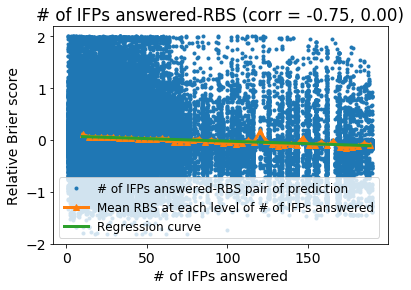

# of IFPs answered-RBS correlation:
(-0.75368323137965199, 6.3039432818184542e-10)


In [19]:
num_ifps_answered = np.array(user_num_ifps_list).squeeze()
#num_resolved_ifp = np.array(user_num_resolved_ifp_answered_list).squeeze()
se_label = np.array(se_list).squeeze()

#print(user_num_ifps_list)
#print(avg_rel_ADBS.shape, num_resolved_ifp.shape, se_label.shape)

valid = (~np.isnan(num_ifps_answered)) & (num_ifps_answered>0) & (~np.isnan(se_label))
#print(valid.shape)
num_ifps_answered = num_ifps_answered[valid]
se_label = se_label[valid]

#print(np.max(num_resolved_ifp))
#print(avg_abs_ADBS)
#print(se_label)


percentiles = 50
interval = 190
#perc_mean_preds = np.zeros(percentiles+1)
#perc_mean_entr = np.zeros(percentiles+1)
#perc_mean_wager = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
#perc_mean_mse_rate = np.zeros(percentiles+1)
#perc_mean_rank = np.zeros(percentiles+1)
for i in range(percentiles+1):
    center = interval / percentiles * i + 10
    head = center - interval / percentiles * 0.5
    tail = center + interval / percentiles * 0.5
    valid = (num_ifps_answered>=head) & (num_ifps_answered<tail)
    #perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    #perc_mean_entr[i] = np.mean(vec_entr[valid])
    #perc_mean_rank[i] = np.mean(vec_rank[valid])
    #perc_mean_wager[i] = np.mean(vec_wager[valid & vec_valid_wager])
    perc_mean_mse[i] = np.mean(se_label[valid])
    #perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
x_axis = np.arange(percentiles+1) / percentiles * interval + 10

plt.figure(1)
plt.plot(num_ifps_answered, se_label,'.', label="# of IFPs answered-RBS pair of prediction")
x = x_axis[~np.isnan(perc_mean_mse)]
y = perc_mean_mse[~np.isnan(perc_mean_mse)]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
plt.plot(x, y, '-^', linewidth=3, markersize=6, label="Mean RBS at each level of # of IFPs answered")
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
#plt.xlim([-2,-2+interval])
plt.xlabel('# of IFPs answered')
plt.ylabel('Relative Brier score')
plt.legend(prop={'size': 12})
plt.title('# of IFPs answered-RBS (corr = -0.75, 0.00)')
plt.savefig('fig0928/IFPs_num_RBS.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close('All')
print('# of IFPs answered-RBS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))

/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


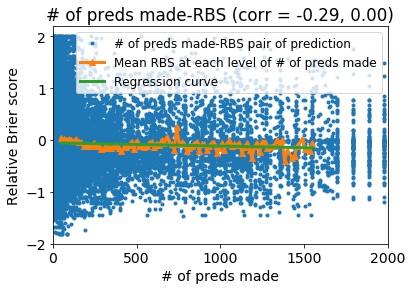

# of preds made-RBS correlation:
(-0.29143089670784761, 0.0037771267379461005)


In [20]:
num_ifps_answered = np.array(user_num_preds_list).squeeze()
#num_resolved_ifp = np.array(user_num_resolved_ifp_answered_list).squeeze()
se_label = np.array(se_list).squeeze()

#print(user_num_ifps_list)
#print(avg_rel_ADBS.shape, num_resolved_ifp.shape, se_label.shape)

valid = (~np.isnan(num_ifps_answered)) & (num_ifps_answered>0) & (~np.isnan(se_label))
#print(valid.shape)
num_ifps_answered = num_ifps_answered[valid]
se_label = se_label[valid]

#print(np.max(num_resolved_ifp))
#print(avg_abs_ADBS)
#print(se_label)


percentiles = 100
interval = 1500
#perc_mean_preds = np.zeros(percentiles+1)
#perc_mean_entr = np.zeros(percentiles+1)
#perc_mean_wager = np.zeros(percentiles+1)
perc_mean_mse = np.zeros(percentiles+1)
#perc_mean_mse_rate = np.zeros(percentiles+1)
#perc_mean_rank = np.zeros(percentiles+1)
for i in range(percentiles+1):
    center = interval / percentiles * i + 50
    head = center - interval / percentiles * 0.5
    tail = center + interval / percentiles * 0.5
    valid = (num_ifps_answered>=head) & (num_ifps_answered<tail)
    #perc_mean_preds[i] = np.mean(np.abs(vec_preds[valid] - 0.5))
    #perc_mean_entr[i] = np.mean(vec_entr[valid])
    #perc_mean_rank[i] = np.mean(vec_rank[valid])
    #perc_mean_wager[i] = np.mean(vec_wager[valid & vec_valid_wager])
    perc_mean_mse[i] = np.mean(se_label[valid])
    #perc_mean_mse_rate[i] = np.sum(vec_mse[valid]<=0.2) / len(vec_mse[valid])
x_axis = np.arange(percentiles+1) / percentiles * interval + 50

plt.figure(1)
plt.plot(num_ifps_answered, se_label,'.', label="# of preds made-RBS pair of prediction")
x = x_axis[~np.isnan(perc_mean_mse)]
y = perc_mean_mse[~np.isnan(perc_mean_mse)]
A = np.vstack([x, np.ones(len(x))]).T
a1, a2 = np.linalg.lstsq(A, y)[0]
plt.plot(x, y, '-^', linewidth=3, markersize=6, label="Mean RBS at each level of # of preds made")
x = np.linspace(np.min(x),np.max(x),20)
plt.plot(x, x * a1 + a2, linewidth=3, label='Regression curve')
plt.xlim([0,2000])
plt.xlabel('# of preds made')
plt.ylabel('Relative Brier score')
plt.legend(prop={'size': 12})
plt.title('# of preds made-RBS (corr = -0.29, 0.00)')
plt.savefig('fig0928/preds_num_RBS.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close('All')
print('# of preds made-RBS correlation:')
print(st.pearsonr(x_axis[~np.isnan(perc_mean_mse)], perc_mean_mse[~np.isnan(perc_mean_mse)]))

In [30]:
print(raw_preds.shape)
# number of active users of each grounp
print("# of active users of each grounp")
n_volu, n_Turk, n_ctrl = np.sum(raw_user_type==1), np.sum(raw_user_type==2), np.sum(raw_user_type==3)
print(n_volu, n_Turk, n_ctrl)

# number of IFPs answered of each user
n_IFPs_of_each_user = np.sum(raw_preds[-1,:,:,0]>-0.1, axis=0)
print("# of IFPs answered of each user (Mean / Median)")
for i in [1,2,3]:
    samples = n_IFPs_of_each_user[raw_user_type==i]
    print(np.mean(samples), '/', np.median(samples))
    
# number of forecasts of each user
n_fcasts_of_each_user = np.sum(np.sum(raw_preds_age[:,:,:]==0, axis=0), axis=0)
print("# of forecasts of each user (Mean / Median)")
for i in [1,2,3]:
    samples = n_fcasts_of_each_user[raw_user_type==i]
    print(np.mean(samples), '/', np.median(samples))
    
# number of IFPs covered each grounp
print("# of IFPs covered each grounp")
for i in [1,2,3]:
    curr_preds = raw_preds[-1,:,:,0]
    curr_preds = curr_preds[:, raw_user_type==i]
    print(np.sum(np.sum(curr_preds>-0.1, axis=1)>0))
    
# number of users of each IFP
print("# of users of each IFP (Mean / Median)")
for i in [1,2,3]:
    curr_preds = raw_preds[-1,:,:,0]
    curr_preds = curr_preds[:, raw_user_type==i]
    samples = np.sum(curr_preds>-0.1, axis=1)
    print(np.mean(samples), '/', np.median(samples))
    
# number of fcasts of each IFP
print("# of fcasts of each IFP (Mean / Median)")
n_fcasts_of_each_IFP = np.sum(np.sum(raw_preds_age[:,:,:]==0, axis=0), axis=0)
for i in [1,2,3]:
    curr_preds_age = raw_preds_age[:,:,raw_user_type==i]
    samples = np.sum(np.sum(curr_preds_age==0, axis=0), axis=1)
    print(np.mean(samples), '/', np.median(samples))

(185, 191, 2353, 5)
# of active users of each grounp
410 768 1175
# of IFPs answered of each user (Mean / Median)
9.79756097561 / 4.0
36.9778645833 / 47.5
40.730212766 / 36.0
# of forecasts of each user (Mean / Median)
14.4951219512 / 4.0
39.4309895833 / 51.0
55.4953191489 / 40.0
# of IFPs covered each grounp
191
164
191
# of users of each IFP (Mean / Median)
21.0314136126 / 11.0
148.685863874 / 116.0
250.565445026 / 241.0
# of fcasts of each IFP (Mean / Median)
31.1151832461 / 14.0
158.54973822 / 129.0
341.397905759 / 361.0


In [70]:
se_marked_with_nan = np.array(raw_se)
se_marked_with_nan[se_marked_with_nan<-0.1] = np.NAN
se_marked_with_nan[raw_openday<-0.1] = np.NAN
#nan_mark = 1.0 * np.ones_like(raw_openday)
#nan_mark[raw_openday<-0.1] = np.NAN
#se_marked_with_nan *= nan_mark[:, :, None]
avg_daily_se = np.nanmean(se_marked_with_nan, axis=0)

/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


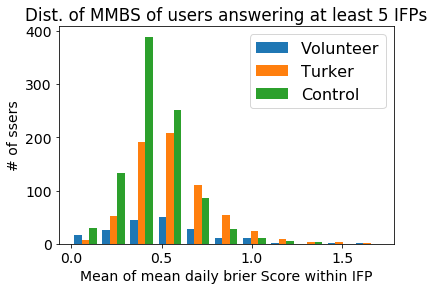

/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


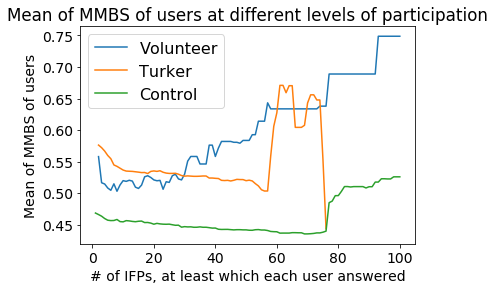

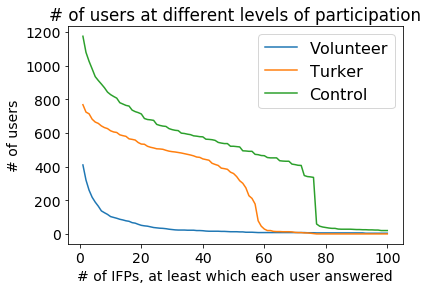

In [77]:
samples = np.nanmean(avg_daily_se, axis=0)
samples[n_IFPs_of_each_user<5]= np.NAN

volu = (raw_user_type==1) & (n_IFPs_of_each_user>=5)
turk = (raw_user_type==2) & (n_IFPs_of_each_user>=5)
cntr = (raw_user_type==3) & (n_IFPs_of_each_user>=5)
plt.figure(1)
hist_rtn = plt.hist([samples[volu], samples[turk], samples[cntr]], bins=11,
                    label=['Volunteer', 'Turker', 'Control'])
plt.legend(fontsize=16)
plt.xlabel('Mean of mean daily brier Score within IFP')
plt.ylabel('# of ssers')
plt.title('Dist. of MMBS of users answering at least 5 IFPs')
plt.savefig('fig0928/Dist_of_MMBS_of_users.jpg', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(2)
labels = ['Volunteer', 'Turker', 'Control']
samples = np.nanmean(avg_daily_se, axis=0)
for i in [1,2,3]:
    
    tmp = samples[raw_user_type==i]
    num = n_IFPs_of_each_user[raw_user_type==i]
    plt.plot(np.arange(1, 101), [np.mean(tmp[num>j]) for j in range(100)], label=labels[i-1])
    
plt.legend(fontsize=16)
plt.xlabel('# of IFPs, at least which each user answered')
plt.ylabel('Mean of MMBS of users')
plt.title('Mean of MMBS of users at different levels of participation')
plt.savefig('fig0928/Mean_of_MMBS_at_different_levels_of_participation.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close('All')

plt.figure(3)
labels = ['Volunteer', 'Turker', 'Control']
for i in [1,2,3]:
    num = n_IFPs_of_each_user[raw_user_type==i]
    plt.plot(np.arange(1, 101), [np.sum(num>j) for j in range(100)], label=labels[i-1])
    
plt.legend(fontsize=16)
plt.xlabel('# of IFPs, at least which each user answered')
plt.ylabel('# of users')
plt.title('# of users at different levels of participation')
plt.savefig('fig0928/number_of_users_at_different_levels_of_participation.jpg', dpi=300, bbox_inches='tight')
plt.show()
plt.close('All')

    

In [2]:
openday = raw_openday[:]
ifps_type = raw_ifps_type[:]
truth = raw_truth[:]


#valid = raw_user_type==1
turk = raw_user_type==2
control = raw_user_type==3
#valid = raw_user_type>0
#indicator = raw_indicator[:, :, valid]
preds = raw_preds[:, :, valid]
conf = raw_conf[:, :, valid]
wager = raw_wager[:, :, valid]
se = raw_se[:, :, valid]
user_type = raw_user_type[valid]
preds_age = raw_preds_age[:, :, valid]


#print(preds)
print(ifps_type)
print(truth)
print(preds.shape)
print(conf.shape)
print(wager.shape)
print(se.shape)
print(openday.shape)
print(preds_age.shape)
#print(agg_preds.shape)
#print(openday[35:70].T)
#print(agg_openday[35:70].T)
#print(ifps_data[['map_id','type']])

[2 5 2 2 3 5 2 5 3 5 5 2 5 5 5 2 2 2 2 2 5 5 2 5 5 3 5 2 5 2 2 5 5 5 4 2 4
 5 2 2 5 5 5 5 3 5 5 5 2 2 5 5 5 3 2 2 4 2 2 2 2 2 2 4 3 2 3 5 2 2 5 2 4 2
 5 2 2 3 5 3 3 2 5 4 2 2 2 3 2 4 3 2 2 2 2 3 5 3 5 2 3 3 5 2 2 2 2 3 2 2 5
 5 3 5 3 3 5 5 2 5 2 2 2 3 5 2 2 3 3 2 3 5 5 2 3 2 5 2 2 2 5 5 2 2 3 5 4 2
 2 2 5 2 5 2 2 4 5 2 2 3 5 2 2 5 2 3 5 2 5 2 5 5 2 2 2 2 5 5 5 2 5 5 5 2 2
 2 2 2 2 5 5]
[  2.   3.   2.   2.   1.   4.   2.   4.   2.   1.   5.   2.   2.   2.   1.
   2.   2.   2.   2.   2.   5.   3.   2.   4.   1.   2.   5.   2.   1.   1.
   1.   5.   4.  nan   3.   2.   4.   1.   2.   2.   1.   3.   1.   4.   1.
   2.   2.   5.   2.   2.   2.   3.   3.   3.   1.   2.   4.   2.   2.   1.
   2.   1.   2.   1.   3.   2.   2.   5.   2.   1.   2.   2.   1.   2.   3.
   2.   1.   1.   3.  nan   2.   2.   4.   3.   2.   2.   1.   2.   1.   1.
   3.   1.   2.   2.   1.   1.   3.   3.   4.   1.   2.   1.  nan   2.   2.
   1.   2.   2.   1.   1.   4.   5.   1.   1.   3.   1.   5.   5.   2.   3.
   

Total number of predictions:
539 777 3338
# of answerred questions:
26 19 26
Ratio of users answering at least 3 questions:
31/195 15/397 240/859
Average # of predictions on a question:
20.7307692308 40.8947368421 128.384615385


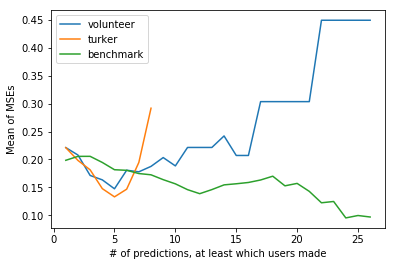

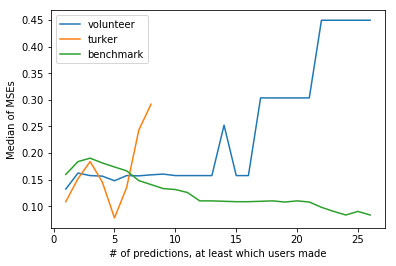

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
save_file = open('preprocessed_HFC_data_matrix_volunteer.npy','rb')
preds_vol = np.load(save_file)
conf_vol = np.load(save_file)
wager_vol = np.load(save_file)
mse_vol = np.load(save_file)
save_file.close()
#valid_wager = wager > -0.1 
#valid_wager[:, np.max(wager, axis=0)<0.1] = False # mark users predict but never wager

save_file = open('preprocessed_HFC_data_matrix_turk.npy','rb')
preds_tur = np.load(save_file)
conf_tur = np.load(save_file)
wager_tur = np.load(save_file)
mse_tur = np.load(save_file)
save_file.close()

save_file = open('preprocessed_HFC_data_matrix_benchmark.npy','rb')
preds_ben = np.load(save_file)
conf_ben = np.load(save_file)
wager_ben = np.load(save_file)
mse_ben = np.load(save_file)
save_file.close()


print("Total number of predictions:")
print(np.sum(preds_vol>-0.1), np.sum(preds_tur>-0.1), np.sum(preds_ben>-0.1))
print("# of answerred questions:")
print(np.sum(np.sum(preds_vol>-0.1, axis=1)>0),
      np.sum(np.sum(preds_tur>-0.1, axis=1)>0),
      np.sum(np.sum(preds_ben>-0.1, axis=1)>0)
     )
print("Ratio of users answering at least 3 questions:")
print(str(np.sum(np.sum(preds_vol>-0.1, axis=0)>=5))+'/'+str(np.sum(np.sum(preds_vol>-0.1, axis=0)>=1)), 
      str(np.sum(np.sum(preds_tur>-0.1, axis=0)>=5))+'/'+str(np.sum(np.sum(preds_tur>-0.1, axis=0)>=1)),
      str(np.sum(np.sum(preds_ben>-0.1, axis=0)>=5))+'/'+str(np.sum(np.sum(preds_ben>-0.1, axis=0)>=1))
     )


ans_vol = np.sum(preds_vol>-0.1, axis=0)
ans_tur = np.sum(preds_tur>-0.1, axis=0)
ans_ben = np.sum(preds_ben>-0.1, axis=0)

weight_vol = np.ones_like(mse_vol)
weight_tur = np.ones_like(mse_tur)
weight_ben = np.ones_like(mse_ben)
weight_vol[mse_vol < -0.1] = 0
weight_tur[mse_tur < -0.1] = 0
weight_ben[mse_ben < -0.1] = 0

print("Average # of predictions on a question:")
print(np.sum(preds_vol>-0.1) / 26, 
      np.sum(preds_tur>-0.1) / 19,
      np.sum(preds_ben>-0.1) / 26,
     )

#print("Average mse:")
#print(np.mean(np.average(mse_vol[:, ans_vol>=1], weights=weight_vol[:, ans_vol>=1], axis=0)),
#      np.mean(np.average(mse_tur[:, ans_tur>=1], weights=weight_tur[:, ans_tur>=1], axis=0)),
#      np.mean(np.average(mse_ben[:, ans_ben>=1], weights=weight_ben[:, ans_ben>=1], axis=0))
#     )
#print("Median mse:")
#print(np.median(np.average(mse_vol[:, ans_vol>=1], weights=weight_vol[:, ans_vol>=1], axis=0)),
#      np.median(np.average(mse_tur[:, ans_tur>=1], weights=weight_tur[:, ans_tur>=1], axis=0)),
#      np.median(np.average(mse_ben[:, ans_ben>=1], weights=weight_ben[:, ans_ben>=1], axis=0))
#     )

plt.figure(4)
plt.plot(np.arange(1, max(ans_vol)+1), 
         [np.mean(np.average(mse_vol[:, ans_vol>=i], weights=weight_vol[:, ans_vol>=i], axis=0)) 
          for i in np.arange(1, max(ans_vol)+1)],
         label = 'volunteer'
        )
plt.plot(np.arange(1, max(ans_tur)+1), 
         [np.mean(np.average(mse_tur[:, ans_tur>=i], weights=weight_tur[:, ans_tur>=i], axis=0)) 
          for i in np.arange(1, max(ans_tur)+1)],
         label = 'turker'
        )
plt.plot(np.arange(1, max(ans_ben)+1), 
         [np.mean(np.average(mse_ben[:, ans_ben>=i], weights=weight_ben[:, ans_ben>=i], axis=0)) 
          for i in np.arange(1, max(ans_ben)+1)],
         label = 'benchmark'
        )
plt.xlabel('# of predictions, at least which users made')
plt.ylabel('Mean of MSEs')
plt.legend()
plt.show()

plt.figure(5)
plt.plot(np.arange(1, max(ans_vol)+1), 
         [np.median(np.average(mse_vol[:, ans_vol>=i], weights=weight_vol[:, ans_vol>=i], axis=0)) 
          for i in np.arange(1, max(ans_vol)+1)],
         label = 'volunteer'
        )
plt.plot(np.arange(1, max(ans_tur)+1), 
         [np.median(np.average(mse_tur[:, ans_tur>=i], weights=weight_tur[:, ans_tur>=i], axis=0)) 
          for i in np.arange(1, max(ans_tur)+1)],
         label = 'turker'
        )
plt.plot(np.arange(1, max(ans_ben)+1), 
         [np.median(np.average(mse_ben[:, ans_ben>=i], weights=weight_ben[:, ans_ben>=i], axis=0)) 
          for i in np.arange(1, max(ans_ben)+1)],
         label = 'benchmark'
        )
plt.xlabel('# of predictions, at least which users made')
plt.ylabel('Median of MSEs')
plt.legend()
plt.show()

plt.close('All')

#tmp = refined_mse_vol[:,2]
#print(np.mean(tmp[tmp>=-0.1]))
#print(tmp)
#print(preds_vol[:, np.sum(preds_vol>-0.1, axis=0)>0][:,2])
#print(preds_vol[:,:10])
#print(np.average(refined_mse_vol, weights=weight_vol, axis=0))

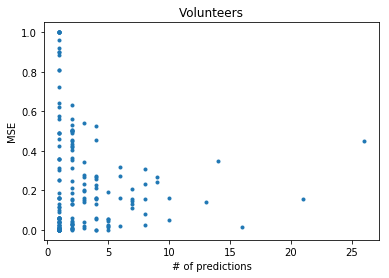

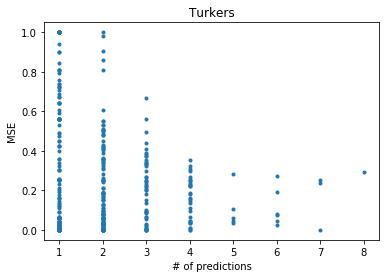

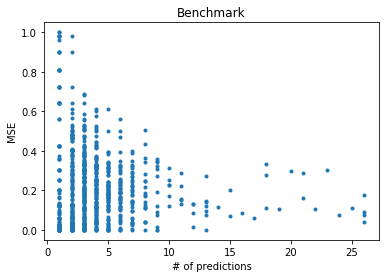

In [63]:
plt.figure(1)
plt.plot(ans_vol[ans_vol>=1], np.average(mse_vol[:, ans_vol>=1], weights=weight_vol[:, ans_vol>=1], axis=0),'.')
plt.xlabel('# of predictions')
plt.ylabel('MSE')
plt.title('Volunteers')
plt.show()

plt.figure(2)
plt.plot(ans_tur[ans_tur>=1], np.average(mse_tur[:, ans_tur>=1], weights=weight_tur[:, ans_tur>=1], axis=0),'.')
plt.xlabel('# of predictions')
plt.ylabel('MSE')
plt.title('Turkers')
plt.show()

plt.figure(3)
plt.plot(ans_ben[ans_ben>=1], np.average(mse_ben[:, ans_ben>=1], weights=weight_ben[:, ans_ben>=1], axis=0),'.')
plt.xlabel('# of predictions')
plt.ylabel('MSE')
plt.title('Benchmark')
plt.show()

plt.close('All')